# Individual Run Timeseries Analysis

This notebook analyzes the timeseries data from a single experiment run to understand system behavior over time.

## Analysis Focus
- System performance evolution across burn-in and main periods
- Queue state dynamics (agent utilization, queue length, workload intensity)
- Case flow patterns (arrivals, completions, queue wait times)
- Daily snapshots of system metrics
- Impact of prioritization scheme changes

## Example Run
- **Run ID**: 15 (from contrast experiment)
- **Data Source**: `experiments/contrast_experiment/15/`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuration
RUN_ID = "15"  # Change this to analyze different runs
EXPERIMENT_DIR = Path("../experiments/contrast_experiment")
RUN_DIR = EXPERIMENT_DIR / RUN_ID

print(f"Analyzing run: {RUN_ID}")
print(f"Run directory: {RUN_DIR}")
print(f"Directory exists: {RUN_DIR.exists()}")


Analyzing run: 15
Run directory: ../experiments/contrast_experiment/15
Directory exists: True


## 1. Load Run Data


In [2]:
def load_run_data(run_dir):
    """Load all data files for a single run."""
    data = {}
    
    # Load timeseries data
    timeseries_file = run_dir / f"{run_dir.name}_timeseries.csv"
    if timeseries_file.exists():
        data['timeseries'] = pd.read_csv(timeseries_file)
        print(f"✓ Loaded timeseries: {data['timeseries'].shape}")
    else:
        print(f"❌ Timeseries file not found: {timeseries_file}")
        data['timeseries'] = None
    
    # Load case database
    case_db_file = run_dir / f"{run_dir.name}_case_DB.csv"
    if case_db_file.exists():
        data['case_db'] = pd.read_csv(case_db_file)
        print(f"✓ Loaded case database: {data['case_db'].shape}")
    else:
        print(f"❌ Case database file not found: {case_db_file}")
        data['case_db'] = None
    
    # Load event log
    evlog_file = run_dir / f"{run_dir.name}_log.csv"
    if evlog_file.exists():
        data['evlog'] = pd.read_csv(evlog_file)
        print(f"✓ Loaded event log: {data['evlog'].shape}")
    else:
        print(f"❌ Event log file not found: {evlog_file}")
        data['evlog'] = None
    
    # Load model metrics
    model_file = run_dir / "models" / "dynamic_throughput_model.json"
    if model_file.exists():
        with open(model_file, 'r') as f:
            data['model_metrics'] = json.load(f)
        print(f"✓ Loaded model metrics")
    else:
        print(f"❌ Model metrics file not found: {model_file}")
        data['model_metrics'] = None
    
    # Load experiment parameters from parent summary
    summary_file = EXPERIMENT_DIR / "experiment_summary.csv"
    if summary_file.exists():
        summary_df = pd.read_csv(summary_file)
        run_params = summary_df[summary_df['seed'] == int(run_dir.name)]
        if len(run_params) > 0:
            data['run_params'] = run_params.iloc[0].to_dict()
            print(f"✓ Loaded run parameters")
        else:
            print(f"❌ Run parameters not found in summary")
            data['run_params'] = None
    else:
        print(f"⚠️  Experiment summary not found: {summary_file}")
        print(f"   Analysis will continue with limited parameter information")
        data['run_params'] = None
    
    return data

# Load the data
if RUN_DIR.exists():
    run_data = load_run_data(RUN_DIR)
else:
    print("❌ Run directory does not exist!")
    run_data = None


✓ Loaded timeseries: (450, 28)
✓ Loaded case database: (1050, 24)
✓ Loaded event log: (2090, 50)
✓ Loaded model metrics
⚠️  Experiment summary not found: ../experiments/contrast_experiment/experiment_summary.csv
   Analysis will continue with limited parameter information


In [3]:
# Display run overview
if run_data and run_data['run_params']:
    print("📊 RUN OVERVIEW")
    print("=" * 50)
    params = run_data['run_params']
    
    print(f"🔢 Run Parameters:")
    print(f"   Seed: {params.get('seed', 'N/A')}")
    print(f"   Priority Scheme: {params.get('P_scheme', 'N/A')}")
    print(f"   Agents: {params.get('agents', 'N/A')}")
    print(f"   Days: {params.get('F_days', 'N/A')}")
    print(f"   Burn-in: {params.get('F_burn_in', 'N/A')}")
    print(f"   Throughput Model: {params.get('F_throughput_model', 'N/A')}")
    print(f"   Model Penalty: {params.get('F_throughput_model_penalty', 'N/A')}")
    
    if run_data['model_metrics']:
        print(f"\n🤖 Model Performance:")
        model = run_data['model_metrics']
        print(f"   Training Successful: {model.get('training_successful', 'N/A')}")
        print(f"   Model Type: {model.get('model_type', 'N/A')}")
        print(f"   Features: {model.get('n_features', 'N/A')}")
        print(f"   Training Samples: {model.get('n_training_samples', 'N/A')}")
        if model.get('mae_burnin'):
            print(f"   MAE Burn-in: {model.get('mae_burnin', 'N/A'):.2f} minutes")
        if model.get('mae_main'):
            print(f"   MAE Main: {model.get('mae_main', 'N/A'):.2f} minutes")
    
    if run_data['timeseries'] is not None:
        ts = run_data['timeseries']
        print(f"\n📈 Timeseries Data:")
        print(f"   Days simulated: {len(ts)}")
        print(f"   Columns: {len(ts.columns)}")
        
        # Check for queue state columns
        daily_queue_cols = [col for col in ts.columns if col.startswith('daily_')]
        print(f"   Daily queue features: {len(daily_queue_cols)}")
        
else:
    print("❌ Unable to load run data or parameters")


❌ Unable to load run data or parameters


## 2. System Performance Evolution


⚠️  Burn-in parameter not available from run params, assuming no burn-in period
Analyzing 450 days of simulation data
Main period: days 0-449 (no burn-in)
All 450 days treated as main period


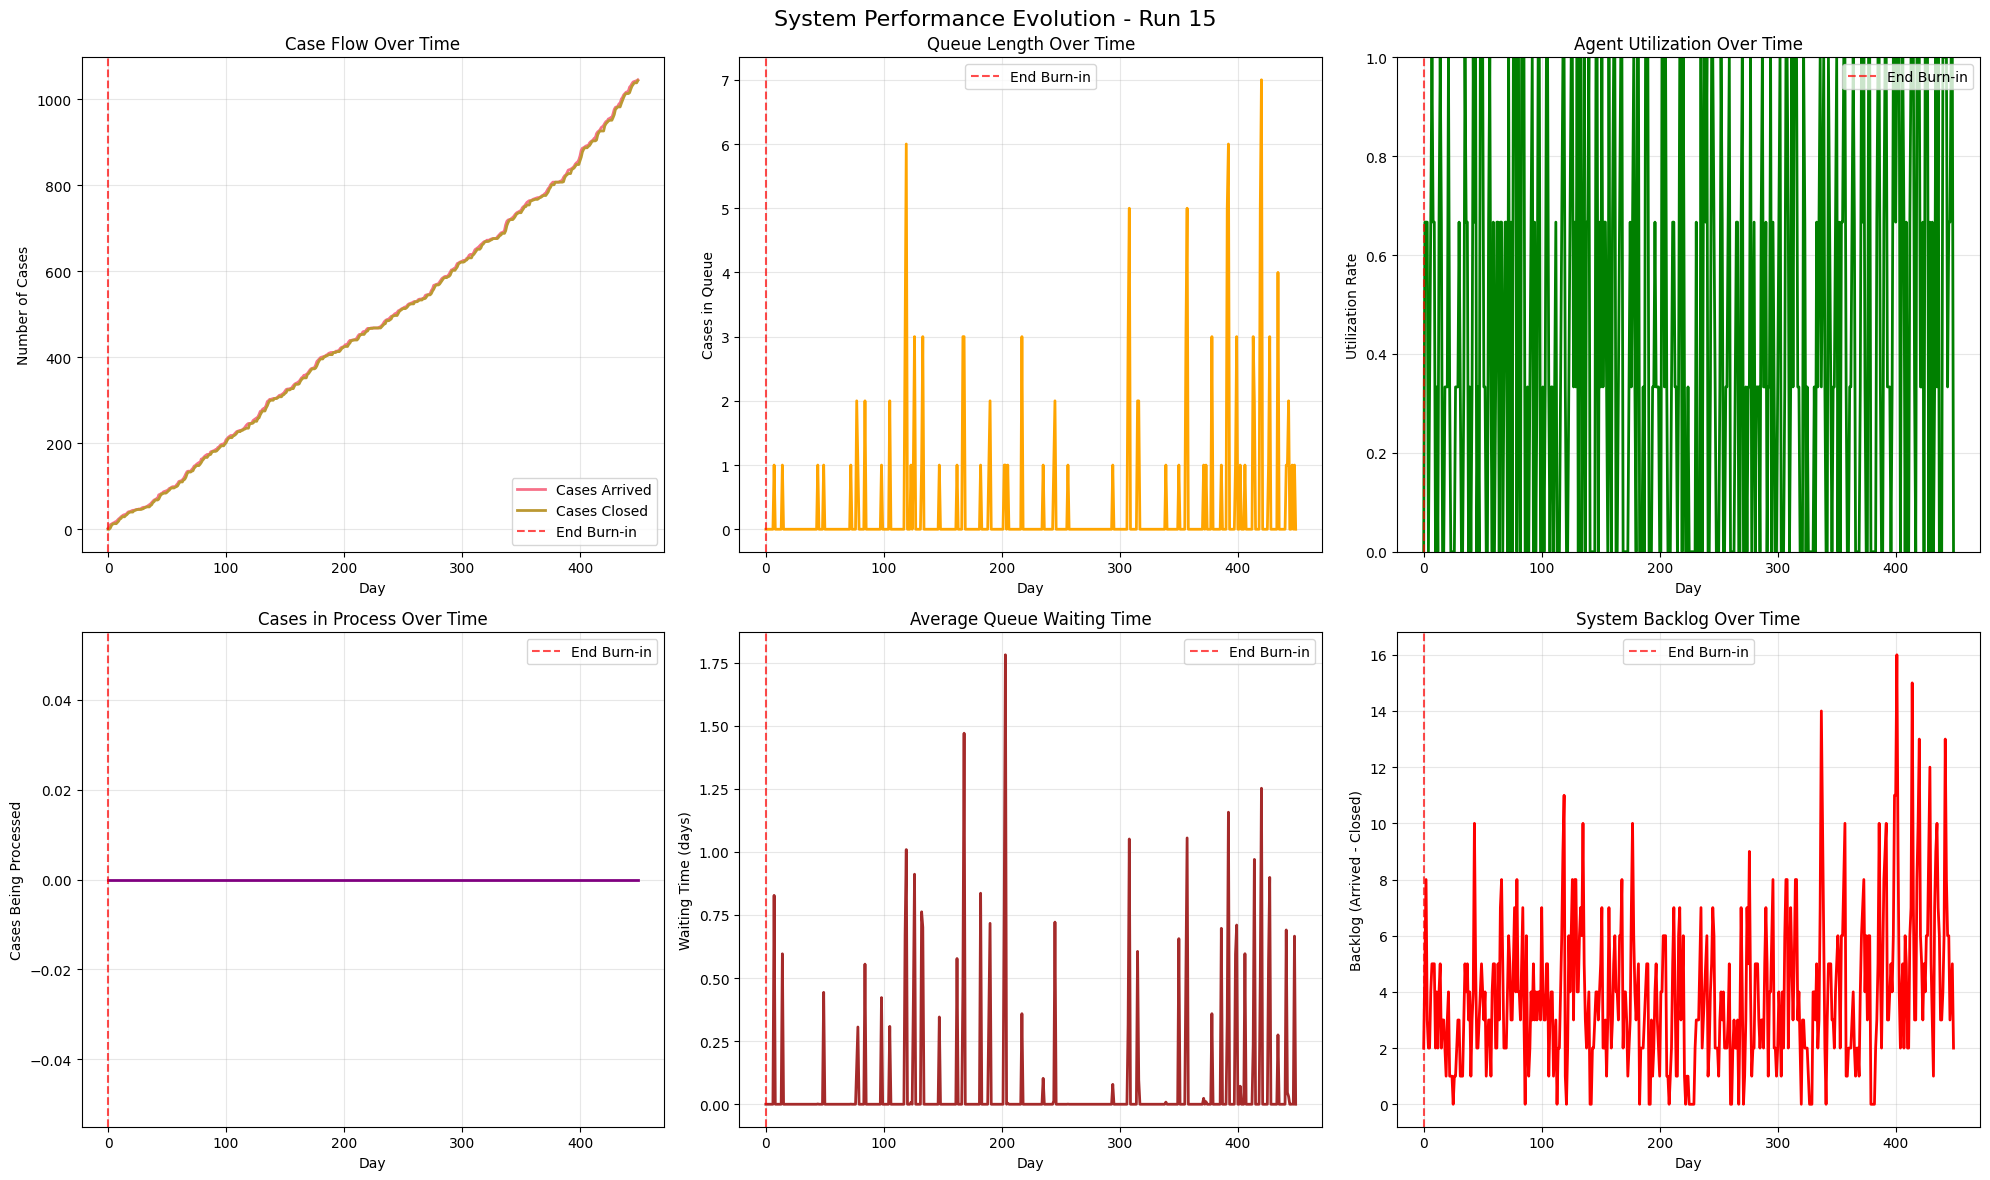

In [4]:
if run_data and run_data['timeseries'] is not None:
    ts = run_data['timeseries'].copy()
    burn_in_days = run_data['run_params'].get('F_burn_in', 0) if run_data['run_params'] else 0
    
    # Handle missing burn-in parameter by detecting from data
    if burn_in_days == 0 and len(ts) > 0:
        # Try to detect burn-in period from data (typically around 50-100 days)
        # For now, assume no burn-in if parameters not available
        print("⚠️  Burn-in parameter not available from run params, assuming no burn-in period")
    
    # Add period indicator
    ts['period'] = ts['day'].apply(lambda x: 'Burn-in' if x < burn_in_days else 'Main')
    
    print(f"Analyzing {len(ts)} days of simulation data")
    if burn_in_days > 0:
        print(f"Burn-in period: days 0-{burn_in_days-1}")
        print(f"Main period: days {burn_in_days}-{ts['day'].max()}")
    else:
        print(f"Main period: days 0-{ts['day'].max()} (no burn-in)")
        print(f"All {len(ts)} days treated as main period")
    
    # Core system metrics over time
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'System Performance Evolution - Run {RUN_ID}', fontsize=16)
    
    # Cases arrived vs closed
    axes[0,0].plot(ts['day'], ts['n_cases_arrived'], label='Cases Arrived', linewidth=2)
    axes[0,0].plot(ts['day'], ts['n_cases_closed_total'], label='Cases Closed', linewidth=2)
    axes[0,0].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[0,0].set_title('Case Flow Over Time')
    axes[0,0].set_xlabel('Day')
    axes[0,0].set_ylabel('Number of Cases')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Queue length evolution
    axes[0,1].plot(ts['day'], ts['n_cases_waiting_in_queue'], linewidth=2, color='orange')
    axes[0,1].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[0,1].set_title('Queue Length Over Time')
    axes[0,1].set_xlabel('Day')
    axes[0,1].set_ylabel('Cases in Queue')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Agent utilization
    axes[0,2].plot(ts['day'], ts['n_busy_agents'] / ts['n_agents'], linewidth=2, color='green')
    axes[0,2].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[0,2].set_title('Agent Utilization Over Time')
    axes[0,2].set_xlabel('Day')
    axes[0,2].set_ylabel('Utilization Rate')
    axes[0,2].set_ylim(0, 1)
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Cases in process
    axes[1,0].plot(ts['day'], ts['n_cases_in_process'], linewidth=2, color='purple')
    axes[1,0].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[1,0].set_title('Cases in Process Over Time')
    axes[1,0].set_xlabel('Day')
    axes[1,0].set_ylabel('Cases Being Processed')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Average queue waiting time
    axes[1,1].plot(ts['day'], ts['avg_current_queue_waitingtime'], linewidth=2, color='brown')
    axes[1,1].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[1,1].set_title('Average Queue Waiting Time')
    axes[1,1].set_xlabel('Day')
    axes[1,1].set_ylabel('Waiting Time (days)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # System backlog (arrived - closed)
    ts['backlog'] = ts['n_cases_arrived'] - ts['n_cases_closed_total']
    axes[1,2].plot(ts['day'], ts['backlog'], linewidth=2, color='red')
    axes[1,2].axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
    axes[1,2].set_title('System Backlog Over Time')
    axes[1,2].set_xlabel('Day')
    axes[1,2].set_ylabel('Backlog (Arrived - Closed)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("❌ No timeseries data available for analysis")


## 3. Queue State Features Analysis


Found 13 daily queue state features:
  ['daily_agents_available', 'daily_agents_busy', 'daily_agent_utilization', 'daily_queue_length', 'daily_cases_in_process']...


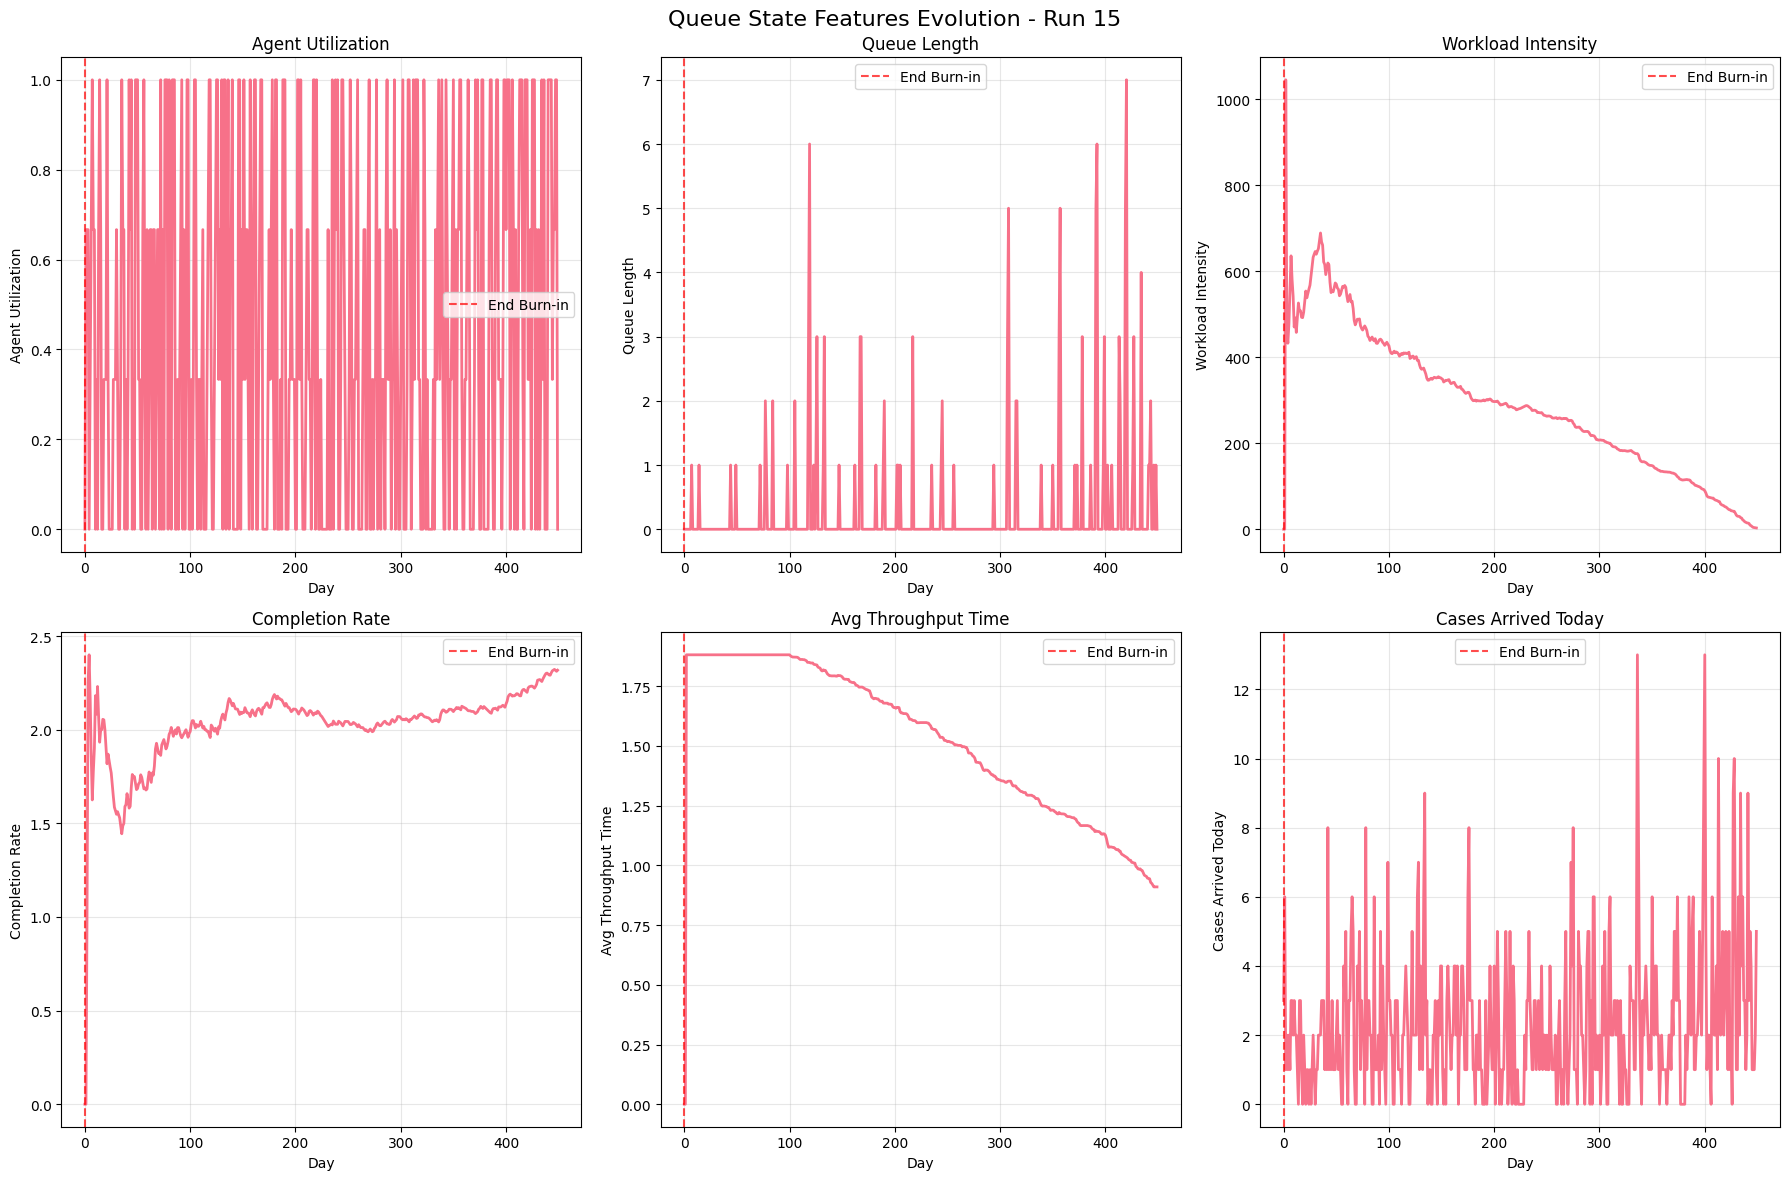


📊 Queue State Features Summary by Period:


KeyError: 'period'

In [5]:
# Analyze the new queue state features over time
if run_data and run_data['timeseries'] is not None:
    ts = run_data['timeseries']
    
    # Find daily queue state columns
    daily_queue_cols = [col for col in ts.columns if col.startswith('daily_')]
    print(f"Found {len(daily_queue_cols)} daily queue state features:")
    print(f"  {daily_queue_cols[:5]}..." if len(daily_queue_cols) > 5 else f"  {daily_queue_cols}")
    
    if daily_queue_cols:
        # Key queue state metrics
        key_metrics = {
            'daily_agent_utilization': 'Agent Utilization',
            'daily_queue_length': 'Queue Length', 
            'daily_workload_intensity': 'Workload Intensity',
            'daily_recent_completion_rate': 'Completion Rate',
            'daily_recent_avg_throughput_time': 'Avg Throughput Time',
            'daily_cases_arrived_today': 'Cases Arrived Today'
        }
        
        # Filter to available metrics
        available_metrics = {k: v for k, v in key_metrics.items() if k in ts.columns}
        
        if available_metrics:
            # Plot queue state evolution
            n_metrics = len(available_metrics)
            n_cols = 3
            n_rows = (n_metrics + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            fig.suptitle(f'Queue State Features Evolution - Run {RUN_ID}', fontsize=16)
            
            for i, (col, title) in enumerate(available_metrics.items()):
                row, col_idx = i // n_cols, i % n_cols
                ax = axes[row, col_idx]
                
                # Plot the metric
                ax.plot(ts['day'], ts[col], linewidth=2)
                ax.axvline(burn_in_days, color='red', linestyle='--', alpha=0.7, label='End Burn-in')
                ax.set_title(title)
                ax.set_xlabel('Day')
                ax.set_ylabel(title)
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # Hide empty subplots
            for i in range(len(available_metrics), n_rows * n_cols):
                row, col_idx = i // n_cols, i % n_cols
                axes[row, col_idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()
            
            # Statistical summary by period
            print("\n📊 Queue State Features Summary by Period:")
            burnin_data = ts[ts['period'] == 'Burn-in'][list(available_metrics.keys())]
            main_data = ts[ts['period'] == 'Main'][list(available_metrics.keys())]
            
            summary_stats = []
            for col, title in available_metrics.items():
                burnin_mean = burnin_data[col].mean()
                main_mean = main_data[col].mean()
                change = main_mean - burnin_mean
                pct_change = ((main_mean - burnin_mean) / burnin_mean * 100) if burnin_mean != 0 else 0
                
                summary_stats.append({
                    'Metric': title,
                    'Burn-in Mean': f"{burnin_mean:.3f}",
                    'Main Mean': f"{main_mean:.3f}",
                    'Change': f"{change:.3f}",
                    'Change %': f"{pct_change:.1f}%"
                })
            
            summary_df = pd.DataFrame(summary_stats)
            display(summary_df)
        
        else:
            print("❌ None of the expected queue state metrics found in timeseries data")
    
    else:
        print("❌ No daily queue state features found in timeseries data")

else:
    print("❌ No timeseries data available for queue state analysis")


## 4. Case-Level Analysis with Queue Features


Analyzing case database with 1188 cases
Queue state features in case DB: 13
Burn-in cases: 0
Main period cases: 1188
Main cases with queue features: 1172/1188 (98.7%)


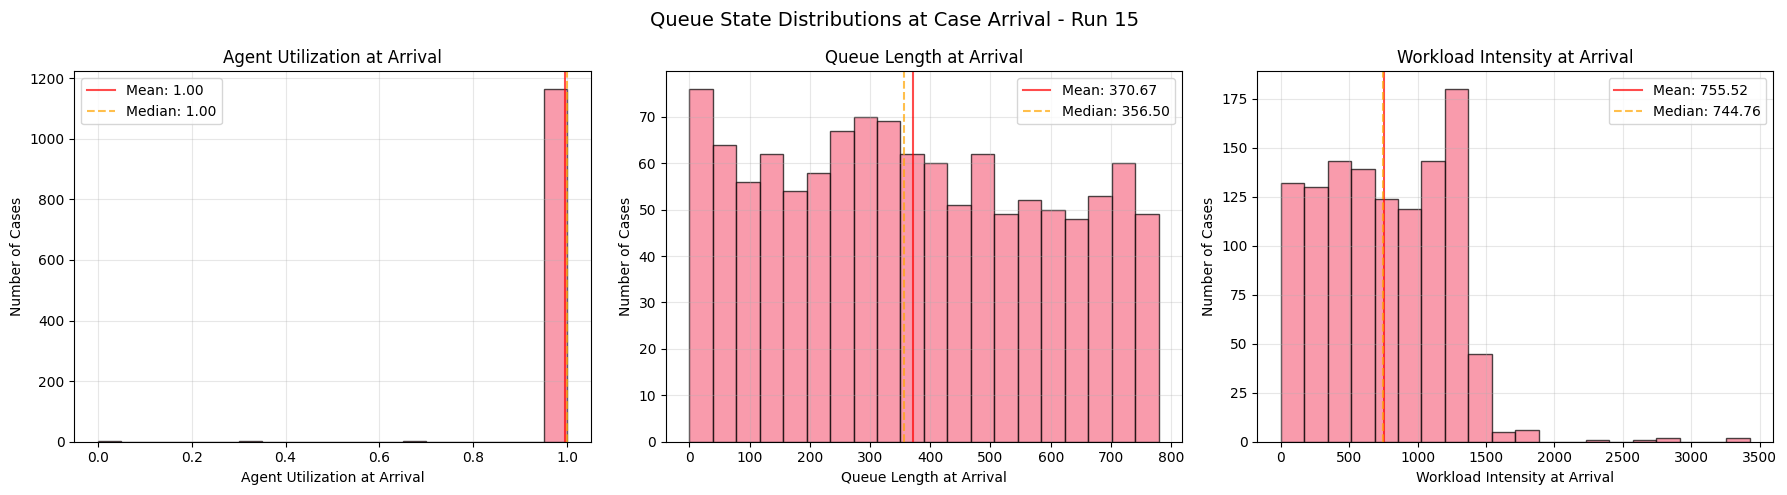

\n🔗 Correlation Analysis: Queue Features vs Throughput Time
Correlations with estimated throughput time:
  Agent Utilization at Arrival: 0.015 📈 (Weak)
  Queue Length at Arrival: 0.478 📈 (Moderate)
  Workload Intensity at Arrival: -0.431 📉 (Moderate)


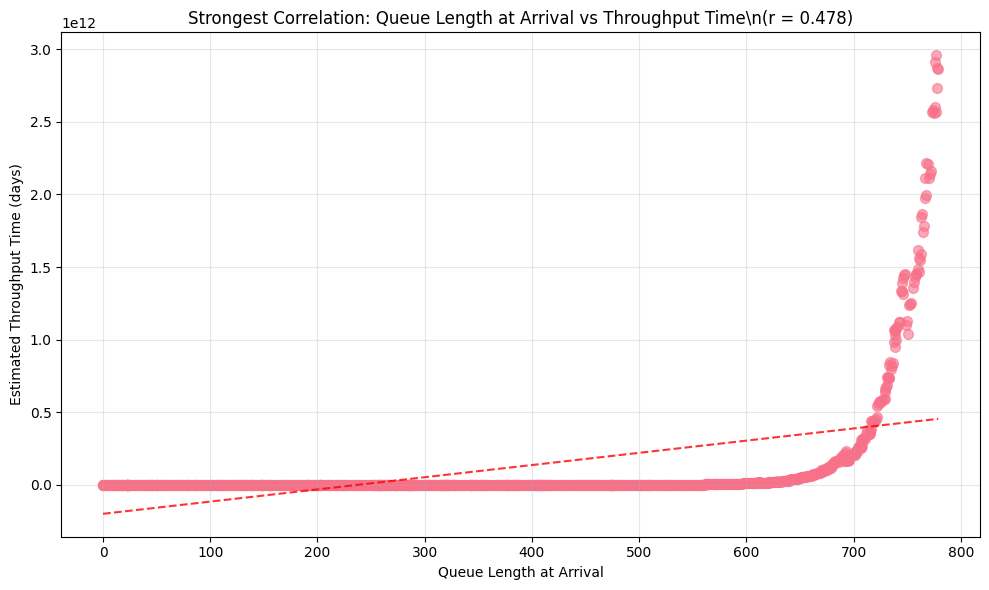

In [18]:
# Analyze case-level data with queue state features
if run_data and run_data['case_db'] is not None:
    case_db = run_data['case_db']
    print(f"Analyzing case database with {len(case_db)} cases")
    
    # Check for queue state features at case level
    case_queue_cols = [col for col in case_db.columns if col.startswith('qs_')]
    print(f"Queue state features in case DB: {len(case_queue_cols)}")
    
    if case_queue_cols:
        # Separate burn-in and main period cases
        burnin_cases = case_db[case_db['arrival_q'] < burn_in_days]
        main_cases = case_db[case_db['arrival_q'] >= burn_in_days]
        
        print(f"Burn-in cases: {len(burnin_cases)}")
        print(f"Main period cases: {len(main_cases)}")
        
        # Check queue feature coverage
        main_with_queue = main_cases[case_queue_cols[0]].notna().sum() if len(main_cases) > 0 else 0
        print(f"Main cases with queue features: {main_with_queue}/{len(main_cases)} ({main_with_queue/len(main_cases)*100:.1f}%)")
        
        if main_with_queue > 0:
            # Key case-level queue metrics to analyze
            key_case_metrics = {
                'qs_agent_utilization': 'Agent Utilization at Arrival',
                'qs_queue_length': 'Queue Length at Arrival',
                'qs_workload_intensity': 'Workload Intensity at Arrival'
            }
            
            # Filter to available metrics
            available_case_metrics = {k: v for k, v in key_case_metrics.items() if k in case_db.columns}
            
            if available_case_metrics:
                # Plot distributions of queue features for main period cases
                n_metrics = len(available_case_metrics)
                fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
                if n_metrics == 1:
                    axes = [axes]
                
                fig.suptitle(f'Queue State Distributions at Case Arrival - Run {RUN_ID}', fontsize=14)
                
                cases_with_queue = main_cases[main_cases[case_queue_cols[0]].notna()]
                
                for i, (col, title) in enumerate(available_case_metrics.items()):
                    values = cases_with_queue[col].dropna()
                    if len(values) > 0:
                        axes[i].hist(values, bins=20, alpha=0.7, edgecolor='black')
                        axes[i].set_title(title)
                        axes[i].set_xlabel(title)
                        axes[i].set_ylabel('Number of Cases')
                        axes[i].grid(True, alpha=0.3)
                        
                        # Add statistics
                        mean_val = values.mean()
                        median_val = values.median()
                        axes[i].axvline(mean_val, color='red', linestyle='-', alpha=0.7, label=f'Mean: {mean_val:.2f}')
                        axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
                        axes[i].legend()
                
                plt.tight_layout()
                plt.show()
                
                # Correlation between queue features and throughput times
                if 'est_throughputtime' in case_db.columns:
                    print("\n🔗 Correlation Analysis: Queue Features vs Throughput Time")
                    
                    corr_data = cases_with_queue[list(available_case_metrics.keys()) + ['est_throughputtime']].corr()
                    
                    # Focus on correlations with throughput time
                    tt_correlations = corr_data['est_throughputtime'].drop('est_throughputtime')
                    
                    print("Correlations with estimated throughput time:")
                    for feature, corr in tt_correlations.items():
                        direction = "📈" if corr > 0 else "📉" if corr < 0 else "➡️"
                        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                        print(f"  {available_case_metrics.get(feature, feature)}: {corr:.3f} {direction} ({strength})")
                    
                    # Scatter plot of strongest correlation
                    if len(tt_correlations) > 0:
                        strongest_feature = tt_correlations.abs().idxmax()
                        strongest_corr = tt_correlations[strongest_feature]
                        
                        plt.figure(figsize=(10, 6))
                        plt.scatter(cases_with_queue[strongest_feature], cases_with_queue['est_throughputtime'], 
                                   alpha=0.6, s=50)
                        plt.xlabel(available_case_metrics[strongest_feature])
                        plt.ylabel('Estimated Throughput Time (days)')
                        plt.title(f'Strongest Correlation: {available_case_metrics[strongest_feature]} vs Throughput Time\n(r = {strongest_corr:.3f})')
                        plt.grid(True, alpha=0.3)
                        
                        # Add trend line
                        z = np.polyfit(cases_with_queue[strongest_feature], cases_with_queue['est_throughputtime'], 1)
                        p = np.poly1d(z)
                        plt.plot(cases_with_queue[strongest_feature], p(cases_with_queue[strongest_feature]), "r--", alpha=0.8)
                        
                        plt.tight_layout()
                        plt.show()
            
            else:
                print("❌ None of the expected case-level queue metrics found")
        
        else:
            print("❌ No main period cases have queue state features")
    
    else:
        print("❌ No queue state features found in case database")

else:
    print("❌ No case database available for analysis")


## 5. Performance Summary and Insights


In [6]:
# Generate comprehensive run summary
print("📋 INDIVIDUAL RUN ANALYSIS SUMMARY")
print("=" * 60)

if run_data:
    params = run_data.get('run_params', {})
    ts = run_data.get('timeseries')
    case_db = run_data.get('case_db')
    model_metrics = run_data.get('model_metrics')
    
    print(f"\n🎯 RUN CONFIGURATION:")
    print(f"   Run ID: {RUN_ID}")
    print(f"   Priority Scheme: {params.get('P_scheme', 'N/A')}")
    print(f"   Simulation Days: {params.get('F_days', 'N/A')} (+ {params.get('F_burn_in', 'N/A')} burn-in)")
    print(f"   Agents: {params.get('agents', 'N/A')}")
    print(f"   Throughput Model: {params.get('F_throughput_model', 'N/A')}")
    
    # System performance summary
    if ts is not None:
        print(f"\n📊 SYSTEM PERFORMANCE:")
        
        # Final day metrics
        final_day = ts.iloc[-1]
        print(f"   Total cases arrived: {final_day['n_cases_arrived']}")
        print(f"   Total cases closed: {final_day['n_cases_closed_total']}")
        print(f"   Final queue length: {final_day['n_cases_waiting_in_queue']}")
        print(f"   Final agent utilization: {final_day['n_busy_agents'] / final_day['n_agents']:.1%}")
        
        # Period comparison
        if burn_in_days > 0:
            burnin_period = ts[ts['day'] < burn_in_days]
            main_period = ts[ts['day'] >= burn_in_days]
            
            if len(burnin_period) > 0 and len(main_period) > 0:
                print(f"\n📈 PERIOD COMPARISON:")
                
                # Average queue length
                burnin_avg_queue = burnin_period['n_cases_waiting_in_queue'].mean()
                main_avg_queue = main_period['n_cases_waiting_in_queue'].mean()
                queue_change = ((main_avg_queue - burnin_avg_queue) / burnin_avg_queue * 100) if burnin_avg_queue > 0 else 0
                
                print(f"   Avg queue length - Burn-in: {burnin_avg_queue:.1f}, Main: {main_avg_queue:.1f} ({queue_change:+.1f}%)")
                
                # Average utilization
                burnin_util = (burnin_period['n_busy_agents'] / burnin_period['n_agents']).mean()
                main_util = (main_period['n_busy_agents'] / main_period['n_agents']).mean()
                util_change = ((main_util - burnin_util) / burnin_util * 100) if burnin_util > 0 else 0
                
                print(f"   Avg utilization - Burn-in: {burnin_util:.1%}, Main: {main_util:.1%} ({util_change:+.1f}%)")
                
                # Average waiting time
                burnin_wait = burnin_period['avg_current_queue_waitingtime'].mean()
                main_wait = main_period['avg_current_queue_waitingtime'].mean()
                wait_change = ((main_wait - burnin_wait) / burnin_wait * 100) if burnin_wait > 0 else 0
                
                print(f"   Avg wait time - Burn-in: {burnin_wait:.2f} days, Main: {main_wait:.2f} days ({wait_change:+.1f}%)")
    
    # Model performance
    if model_metrics:
        print(f"\n🤖 MODEL PERFORMANCE:")
        print(f"   Training successful: {'✓' if model_metrics.get('training_successful') else '✗'}")
        print(f"   Model type: {model_metrics.get('model_type', 'N/A')}")
        print(f"   Features used: {model_metrics.get('n_features', 'N/A')} (expected: 45)")
        print(f"   Training samples: {model_metrics.get('n_training_samples', 'N/A')}")
        
        if model_metrics.get('mae_burnin'):
            print(f"   MAE (burn-in): {model_metrics['mae_burnin']:.1f} minutes")
        if model_metrics.get('mae_main'):
            print(f"   MAE (main): {model_metrics['mae_main']:.1f} minutes")
    
    # Queue features assessment
    if ts is not None:
        daily_queue_cols = [col for col in ts.columns if col.startswith('daily_')]
        print(f"\n🔄 QUEUE STATE FEATURES:")
        print(f"   Daily queue features captured: {len(daily_queue_cols)}/13")
        
        if case_db is not None:
            case_queue_cols = [col for col in case_db.columns if col.startswith('qs_')]
            main_cases = case_db[case_db['arrival_q'] >= burn_in_days] if burn_in_days > 0 else case_db
            main_with_queue = main_cases[case_queue_cols[0]].notna().sum() if len(case_queue_cols) > 0 and len(main_cases) > 0 else 0
            
            print(f"   Case-level queue features: {len(case_queue_cols)}/13")
            print(f"   Main period cases with queue data: {main_with_queue}/{len(main_cases)} ({main_with_queue/len(main_cases)*100:.1f}%)")
    
    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
    
    # System stability
    if ts is not None and len(ts) > 10:
        late_period = ts.tail(10)  # Last 10 days
        queue_std = late_period['n_cases_waiting_in_queue'].std()
        util_std = (late_period['n_busy_agents'] / late_period['n_agents']).std()
        
        if queue_std < 2.0 and util_std < 0.1:
            print(f"   ✅ System appears stable (low queue/utilization variance)")
        else:
            print(f"   ⚠️  System shows variability (queue std: {queue_std:.1f}, util std: {util_std:.3f})")
    
    # Model deployment
    if model_metrics:
        feature_count = model_metrics.get('n_features', 0)
        if feature_count == 45:
            print(f"   ✅ New 45-feature structure successfully deployed")
        elif feature_count > 0:
            print(f"   ⚠️  Unexpected feature count: {feature_count} (expected 45)")
        
        if model_metrics.get('training_successful'):
            print(f"   ✅ Dynamic throughput model trained and operational")
    
    # Queue features
    if case_db is not None:
        case_queue_cols = [col for col in case_db.columns if col.startswith('qs_')]
        if len(case_queue_cols) >= 10:
            print(f"   ✅ Queue state features successfully integrated")
        elif len(case_queue_cols) > 0:
            print(f"   ⚠️  Partial queue state integration ({len(case_queue_cols)} features)")
    
    print(f"\n🚀 ANALYSIS COMPLETE")
    print(f"   This run provides insights into {params.get('P_scheme', 'unknown')} prioritization")
    print(f"   Queue state features enable real-time system analysis")
    print(f"   Data can be used for cross-run comparisons and method evaluation")

else:
    print("❌ No run data available for summary")

print("\n" + "=" * 60)


📋 INDIVIDUAL RUN ANALYSIS SUMMARY

🎯 RUN CONFIGURATION:
   Run ID: 15


AttributeError: 'NoneType' object has no attribute 'get'

## How to Use This Notebook

### For Different Runs
1. **Change the RUN_ID** in the second cell to analyze any run from your contrast experiment
2. **Verify the experiment directory** path matches your setup
3. **Run all cells** to get complete analysis

### Key Outputs
- **System Evolution**: Visualize how performance metrics change over time
- **Queue Dynamics**: Understand agent utilization, queue lengths, and workload patterns  
- **Feature Assessment**: Verify queue state features are captured correctly
- **Period Comparison**: Compare burn-in vs main period performance
- **Correlations**: See how queue conditions relate to throughput predictions

### Adaptable Analysis
- Modify the `key_metrics` dictionaries to focus on different queue features
- Adjust plot parameters and time windows for different perspectives
- Add custom correlation or statistical analyses as needed

This notebook provides a foundation for deep-dive analysis of individual simulation runs with the new queue state features and real-time dynamic predictions.
